In [1]:
# https://spureconomics.com/vecm-estimation-and-interpretation/
import os
os.environ ['APPDATA'] = ''
from pandasgui import show
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import grangercausalitytests
import pandas_datareader.data as web    # pandas 0.19.x and later

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


In [87]:
start_date = '1990-01-01'
end_date = '2024-11-01'

sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')['Adj Close']  #
rates_10yr = yf.download('^TNX', start=start_date, end=end_date, interval='1mo')['Adj Close'] / 100  
cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date).squeeze()
usd = yf.download('DX-Y.NYB', start=start_date, end=end_date, interval='1mo')['Adj Close']/100

log_sp500 = np.log(sp500)
log_cpi = np.log(cpi)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [88]:
# Creation of a DataFrame 
data = pd.DataFrame({
    'SP500': log_sp500,
    'Rates10yr': rates_10yr,
    'Cpi': log_cpi,
    'Usd': usd
}).dropna()
# Assign frequency 
data.index = pd.date_range(start=start_date, periods=len(data), freq='ME')

In [89]:
# Dickey-Fuller test for stationarity 
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    if result[1] > 0.05:
        print(f'{name} is non-stationary.')
    else:
        print(f'{name} is stationary.')
    print('\n')

In [90]:
# ADF test 
adf_test(data['SP500'], 'S&P 500')
adf_test(data['Rates10yr'], 'Rate 10 y')
adf_test(data['Cpi'], 'CPI')
adf_test(data['Usd'], 'USD')

ADF Statistic for S&P 500: -0.5288651092580348
p-value: 0.886259520381243
Critical Values:
1%: -3.4463221132914486
5%: -2.8685808072418824
10%: -2.570520529031954
S&P 500 is non-stationary.


ADF Statistic for Rate 10 y: -2.505121654634662
p-value: 0.11423313900633375
Critical Values:
1%: -3.4464400156784927
5%: -2.868632644097719
10%: -2.5705481612974577
Rate 10 y is non-stationary.


ADF Statistic for CPI: 0.27590187883526524
p-value: 0.9762114604318008
Critical Values:
1%: -3.4469295619737665
5%: -2.8688478565083417
10%: -2.570662885558566
CPI is non-stationary.


ADF Statistic for USD: -2.1313210063881627
p-value: 0.23210815483917124
Critical Values:
1%: -3.4463612216221775
5%: -2.8685980017932917
10%: -2.5705296947685605
USD is non-stationary.


In [91]:
# Put the series in first difference
data_diff = data.diff().dropna()

In [92]:
# Second ADF test to know if the series is stationary in first difference
adf_test(data_diff['SP500'], 'S&P 500')
adf_test(data_diff['Rates10yr'], 'Rate 10 y')
adf_test(data_diff['Cpi'], 'CPI')
adf_test(data_diff['Usd'], 'USD')

ADF Statistic for S&P 500: -20.227869572506563
p-value: 0.0
Critical Values:
1%: -3.4463612216221775
5%: -2.8685980017932917
10%: -2.5705296947685605
S&P 500 is stationary.


ADF Statistic for Rate 10 y: -15.036112783374476
p-value: 9.743609010117385e-28
Critical Values:
1%: -3.4464005219454155
5%: -2.868615280538588
10%: -2.570538905413444
Rate 10 y is stationary.


ADF Statistic for CPI: -3.90580865471452
p-value: 0.0019925120556301317
Critical Values:
1%: -3.4469295619737665
5%: -2.8688478565083417
10%: -2.570662885558566
CPI is stationary.


ADF Statistic for USD: -18.47835250482328
p-value: 2.1349946864545985e-30
Critical Values:
1%: -3.4463612216221775
5%: -2.8685980017932917
10%: -2.5705296947685605
USD is stationary.


In [93]:
# Create a DataFrame with SP500, Rates in first difference, and Oil unchanged
data_diff = pd.DataFrame({
    'SP500': data['SP500'].diff().dropna(),  # First difference for SP500
    'Cpi': data['Cpi'].diff().dropna(),
    'Rates10yr': data['Rates10yr'].diff().dropna(),  # First difference for Rates
    'Usd': data['Usd'].diff().dropna(),

}).dropna()
print(data.tail(1))

              SP500  Rates10yr       Cpi     Usd
2024-05-31  8.57121    0.04571  5.746922  1.0467


In [94]:
# Select the VAR model the lowest AIC VAR model for different lag
model = VAR(data_diff)
lag_order = model.select_order(maxlags=10)  
print(f"Selected lags based on AIC: {lag_order.aic}")
print(lag_order.summary())
# Use the selected lag in the VECM model
selected_lag = lag_order.aic

Selected lags based on AIC: 1
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -37.92      -37.88   3.409e-17      -37.90
1      -38.22*     -38.02*  2.520e-17*     -38.14*
2       -38.21      -37.85   2.551e-17      -38.07
3       -38.19      -37.68   2.588e-17      -37.99
4       -38.17      -37.49   2.646e-17      -37.90
5       -38.13      -37.29   2.771e-17      -37.79
6       -38.12      -37.12   2.796e-17      -37.72
7       -38.11      -36.95   2.821e-17      -37.65
8       -38.06      -36.75   2.950e-17      -37.54
9       -38.03      -36.56   3.053e-17      -37.45
10      -38.02      -36.39   3.075e-17      -37.38
--------------------------------------------------


In [95]:
 # Johansen Test to test the cointegration 
def johansen_test(data_diff):
    johan_test = coint_johansen(data_diff, -1, 1)
    trace_stat = johan_test.lr1
    critical_values = johan_test.cvt[:, 1]  # 5% confidence level
    print('Johansen Cointegration Test')
    print('Trace Statistics:', trace_stat)
    print('Critical Values (5%):', critical_values)
    return trace_stat > critical_values

# Check series are cointegrated
print(johansen_test(data_diff[['SP500', 'Rates10yr', 'Cpi', 'Usd']]))

Johansen Cointegration Test
Trace Statistics: [573.26993167 369.2948882  197.27086212  57.14502358]
Critical Values (5%): [40.1749 24.2761 12.3212  4.1296]
[ True  True  True  True]


In [96]:
# Vector Error Correction Model (VECM)
if johansen_test(data_diff[['SP500', 'Rates10yr', 'Cpi', 'Usd']]).any():
    # Fit VECM with cointegrated variables
    vecm = VECM(data_diff[['SP500', 'Rates10yr', 'Cpi', 'Usd']], k_ar_diff=1, coint_rank=1)
    vecm_fitted = vecm.fit()
    # Print VECM summary
    print(vecm_fitted.summary())
else:
    print("No cointegration detected.")

Johansen Cointegration Test
Trace Statistics: [573.26993167 369.2948882  197.27086212  57.14502358]
Critical Values (5%): [40.1749 24.2761 12.3212  4.1296]
Det. terms outside the coint. relation & lagged endog. parameters for equation SP500
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.SP500        -0.2841      0.052     -5.431      0.000      -0.387      -0.182
L1.Rates10yr    -3.5803      0.821     -4.363      0.000      -5.189      -1.972
L1.Cpi          -2.2224      0.891     -2.493      0.013      -3.969      -0.475
L1.Usd          -0.2454      0.095     -2.593      0.010      -0.431      -0.060
Det. terms outside the coint. relation & lagged endog. parameters for equation Rates10yr
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.SP500        -0.011

[[-0.38209795]
 [ 0.03311763]
 [ 0.00926953]
 [ 0.17564711]]


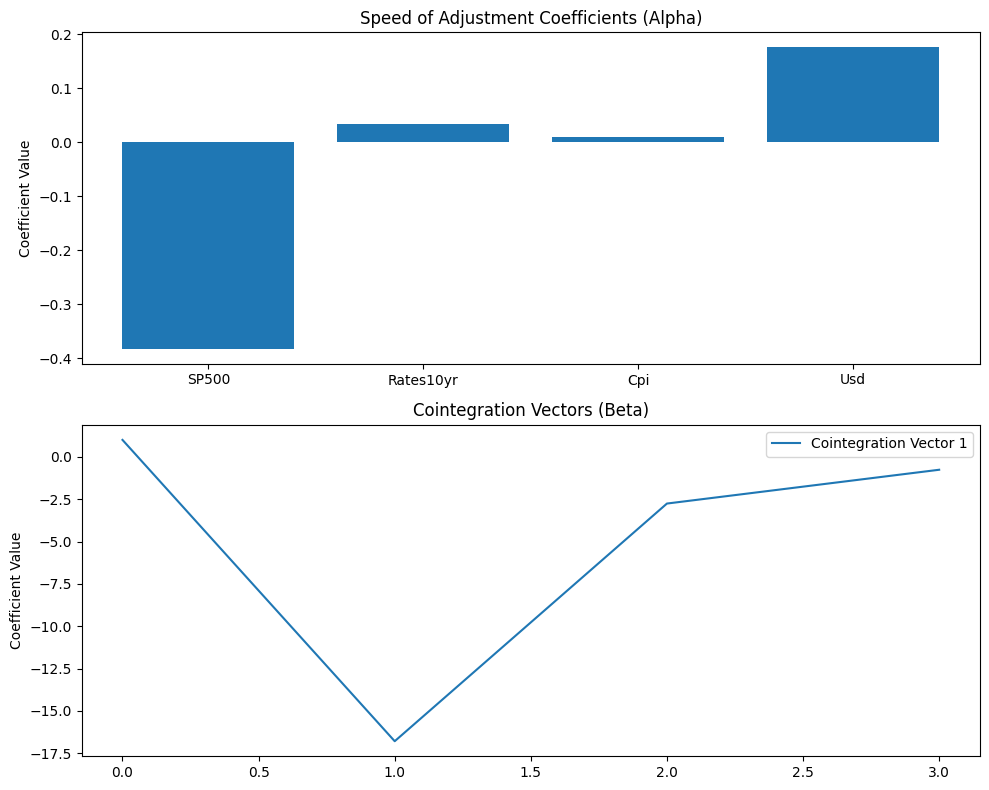

In [97]:
# Assuming vecm_fitted is the fitted VECM model
# Extract the coefficients of the VECM and plot them
coefficients = vecm_fitted.alpha
beta = vecm_fitted.beta
print(coefficients)
# Plot alpha (speed of adjustment coefficients) for the cointegrated variables
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the speed of adjustment coefficients (alpha)
ax[0].bar(['SP500', 'Rates10yr', 'Cpi', 'Usd'], coefficients[:, 0])
ax[0].set_title('Speed of Adjustment Coefficients (Alpha)')
ax[0].set_ylabel('Coefficient Value')

# Plot the cointegration relationship (beta)
for i in range(beta.shape[1]):
    ax[1].plot(beta[:, i], label=f'Cointegration Vector {i+1}')
ax[1].set_title('Cointegration Vectors (Beta)')
ax[1].legend()
ax[1].set_ylabel('Coefficient Value')

# Show the plot
plt.tight_layout()
plt.show()

In [98]:
print('Granger Causality Tests:')
grangercausalitytests(data_diff[['SP500', 'Rates10yr']], maxlag=4)
grangercausalitytests(data_diff[['SP500', 'Cpi']], maxlag=4)
grangercausalitytests(data_diff[['SP500', 'Usd']], maxlag=4)

Granger Causality Tests:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0710  , p=0.7900  , df_denom=408, df_num=1
ssr based chi2 test:   chi2=0.0716  , p=0.7891  , df=1
likelihood ratio test: chi2=0.0716  , p=0.7891  , df=1
parameter F test:         F=0.0710  , p=0.7900  , df_denom=408, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0233  , p=0.9770  , df_denom=405, df_num=2
ssr based chi2 test:   chi2=0.0472  , p=0.9767  , df=2
likelihood ratio test: chi2=0.0472  , p=0.9767  , df=2
parameter F test:         F=0.0233  , p=0.9770  , df_denom=405, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0362  , p=0.9908  , df_denom=402, df_num=3
ssr based chi2 test:   chi2=0.1104  , p=0.9906  , df=3
likelihood ratio test: chi2=0.1104  , p=0.9906  , df=3
parameter F test:         F=0.0362  , p=0.9908  , df_denom=402, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:      

{1: ({'ssr_ftest': (0.009894939540843356, 0.9208113339547231, 408.0, 1),
   'ssr_chi2test': (0.009967696449231908, 0.920472659974855, 1),
   'lrtest': (0.009967575581413257, 0.9204731405487988, 1),
   'params_ftest': (0.009894939540903244, 0.9208113339545425, 408.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.3319352972984174, 0.7177287676227105, 405.0, 2),
   'ssr_chi2test': (0.6720665278634625, 0.714599335037209, 2),
   'lrtest': (0.6715163078160913, 0.7147959555220897, 2),
   'params_ftest': (0.3319352972984608, 0.7177287676226944, 405.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5829301091677643, 0.6264993694253056, 402.0, 3),
   'ssr_chi2test': (1.7792419003702657, 0.6194625153982565, 3),
   'lrtest': (1.7753830365786598, 0.620306457941642, 3),
   'params_ftest': (0.5829301091677711, 0.6264993694253056, 402.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

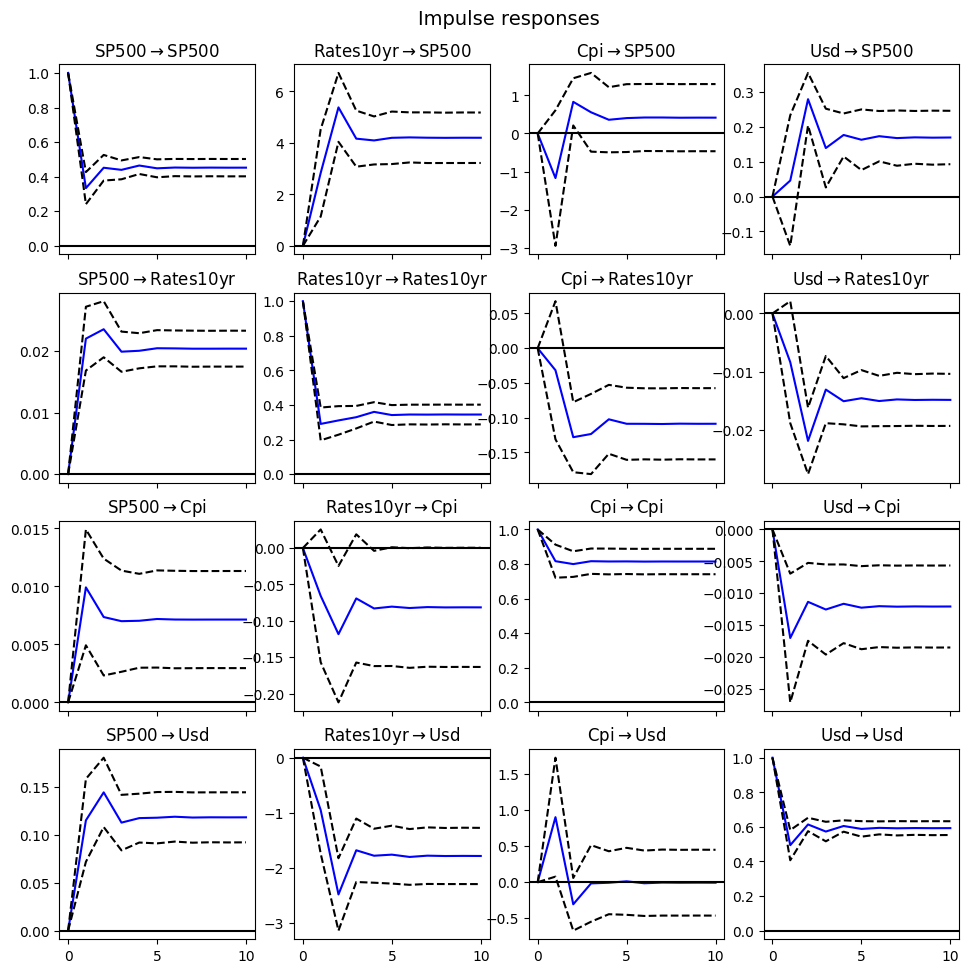

In [99]:
irf = vecm_fitted.irf(10)  # Compute IRF for 10 periods
irf.plot(orth=False)
plt.show()

      SP500       Cpi  Rates10yr       Usd
0  0.027768  0.000626   0.001107 -0.011441
1  0.014756  0.001456   0.001261 -0.002750
2  0.017234  0.001262   0.001114 -0.005261
3  0.019317  0.001113   0.001118 -0.005598
4  0.018638  0.001168   0.001126 -0.005572
5  0.018544  0.001174   0.001130 -0.005390
6  0.018558  0.001172   0.001127 -0.005463
7  0.018607  0.001169   0.001127 -0.005455
8  0.018586  0.001170   0.001127 -0.005459
9  0.018589  0.001170   0.001127 -0.005454


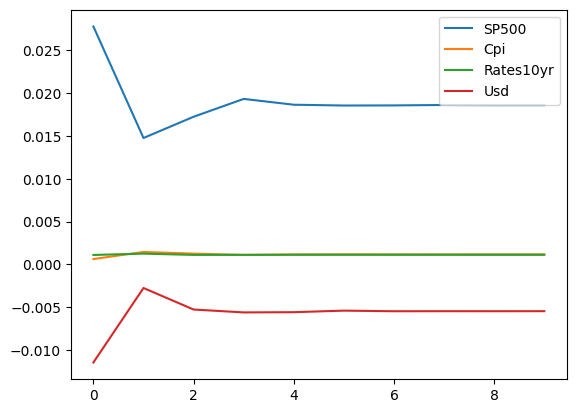

In [100]:
# Forecasting for the next 10 periods
forecast_values = vecm_fitted.predict(steps=10)

# Convert the forecasted values into a DataFrame for better visualization
forecast_df = pd.DataFrame(forecast_values, columns=data_diff.columns)
print(forecast_df)

# Plot the forecasted values
forecast_df.plot()
plt.show()